In [1]:
#imports
import pandas as pd
from IPython.display import display
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifie
import warnings
import deepchem as dc
import matplotlib.pyplot as plt

# Configuring warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=UserWarning, message='.*X does not have valid feature names.*')

from utils.canonicalize import *
from utils.featgen import *
from utils.samplers import *
from utils.tsne import *
from utils.rfcv import *

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
c:\Users\stebi\anaconda3\Lib\site-packages\transformers\adapters\__init__.py:27: FutureWarning: The `adapter-transformers` package is deprecated and replaced by the `adapters` package. See https://docs.adapterhub.ml/transitioning.html.
  warnings.warn(
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (c:\Users\stebi\anaconda3\Lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


### Import datasets and initial preprocessing

In [2]:
df = pd.read_csv(r"./data/train.csv")
test = pd.read_csv(r"./data/test.csv")

In [3]:
df

,smiles,BBB
0,C[N+]1(C)CCC(OC(=O)C(O)(c2ccccc2)C2CCCC2)C1,0
1,C[N+]1(C)CCCC(OC(=O)C(O)(c2ccccc2)c2ccccc2)C1,0
2,C[N+]12CCC(CC1)C(OC(=O)C(O)(c1ccccc1)c1ccccc1)C2,0
3,CC(C)[N+](C)(CCOC(=O)C1c2ccccc2Oc2ccccc21)C(C)C,0
4,CC(C)[N+]1(C)C2CCC1CC(OC(=O)C(CO)c1ccccc1)C2,0
...,...,...
1932,OCCN1CCN(CCCN2c3ccccc3Sc3ccc(C(F)(F)F)cc32)CC1,1
1933,O=C(NCc1ccccc1)OCCO,1
1934,S=P(N1CC1)(N1CC1)N1CC1,1
1935,S=C(NC1CCCCC1)N1CCC(c2cnc[nH]2)CC1,1


In [4]:
test

,smiles,BBB
0,[H]C([H])([H])Oc1ccc(-n2nc3c4ccc(OC([H])([H])[...,1
1,[H]C([H])([H])Oc1ccc2c3nn(-c4ccc(OC)cc4)c(=O)c...,1
2,[H]C([H])([H])Oc1ccccc1-n1nc2c3cc(Cl)ccc3[nH]c...,1
3,[Ar],1
4,Nc1nc2c(ncn2COC(CO)CO)c(=O)[nH]1,1
...,...,...
522,CNC(=NC#N)NCCSCc1[nH]cnc1C,0
523,CN=C(C[N+](=O)[O-])NCCSCc1ccc(CN(C)C)o1,0
524,S=C=S,1
525,CN(C)CCCN1c2ccccc2S(=O)c2ccccc21,1


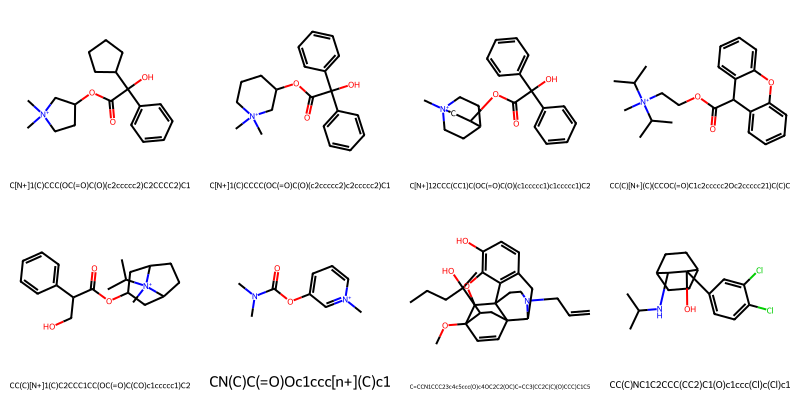

In [5]:
first_four_smiles = df['smiles'].head(8).tolist()
molecules = [Chem.MolFromSmiles(smile) for smile in first_four_smiles]
img = Draw.MolsToGridImage(molecules, molsPerRow=4, subImgSize=(200, 200), legends=first_four_smiles)
display(img)

In [6]:
df = canonicalize_smiles(df, smiles_col='smiles') 
test = canonicalize_smiles(test, smiles_col='smiles') 
duplicate_groups = df[df.duplicated(subset=['smiles'], keep=False)].groupby('smiles')
duplicate_groups = test[test.duplicated(subset=['smiles'], keep=False)].groupby('smiles')
df = df.drop_duplicates(subset='smiles', keep=False)
test = test.drop_duplicates(subset='smiles', keep=False)

### Feature generation for both df

In [7]:
feature_types = ['morgan', 'pubchem', 'rdkit2d', 'maccs', 'daylight', 'physchem']

df = add_molecular_features(df, smiles_col='smiles', feature_types=feature_types)
df = df.rename(columns={'SMILES': 'smiles'})

test = add_molecular_features(test, smiles_col='smiles', feature_types=feature_types)
test = test.rename(columns={'SMILES': 'smiles'})

In [8]:
if set(df.columns) == set(test.columns):
    print("Feature names in both DataFrames are identical.")
else:
    print("Feature names differ.")

    features_only_in_df = set(df.columns) - set(test.columns)
    features_only_in_test = set(test.columns) - set(df.columns)

    if features_only_in_df:
        print("Features only in df:", features_only_in_df)
    if features_only_in_test:
        print("Features only in test:", features_only_in_test)

Feature names in both DataFrames are identical.


### Random samplers to tackel class imbalance


In [9]:
X, y, smiles = prepare_data(df)
df_rus = under_sample(X, y, smiles)
df_ros = over_sample(X, y, smiles)

print("Original class distribution:")
print(df['BBB'].value_counts())
print("Random Under-Sampling class distribution:")
print(df_rus['BBB'].value_counts())
print("\nRandom Over-Sampling class distribution:")
print(df_ros['BBB'].value_counts())

Original class distribution:
1    1476
0     461
Name: BBB, dtype: int64
Random Under-Sampling class distribution:
0    461
1    461
Name: BBB, dtype: int64

Random Over-Sampling class distribution:
0    1476
1    1476
Name: BBB, dtype: int64


### t-SNE

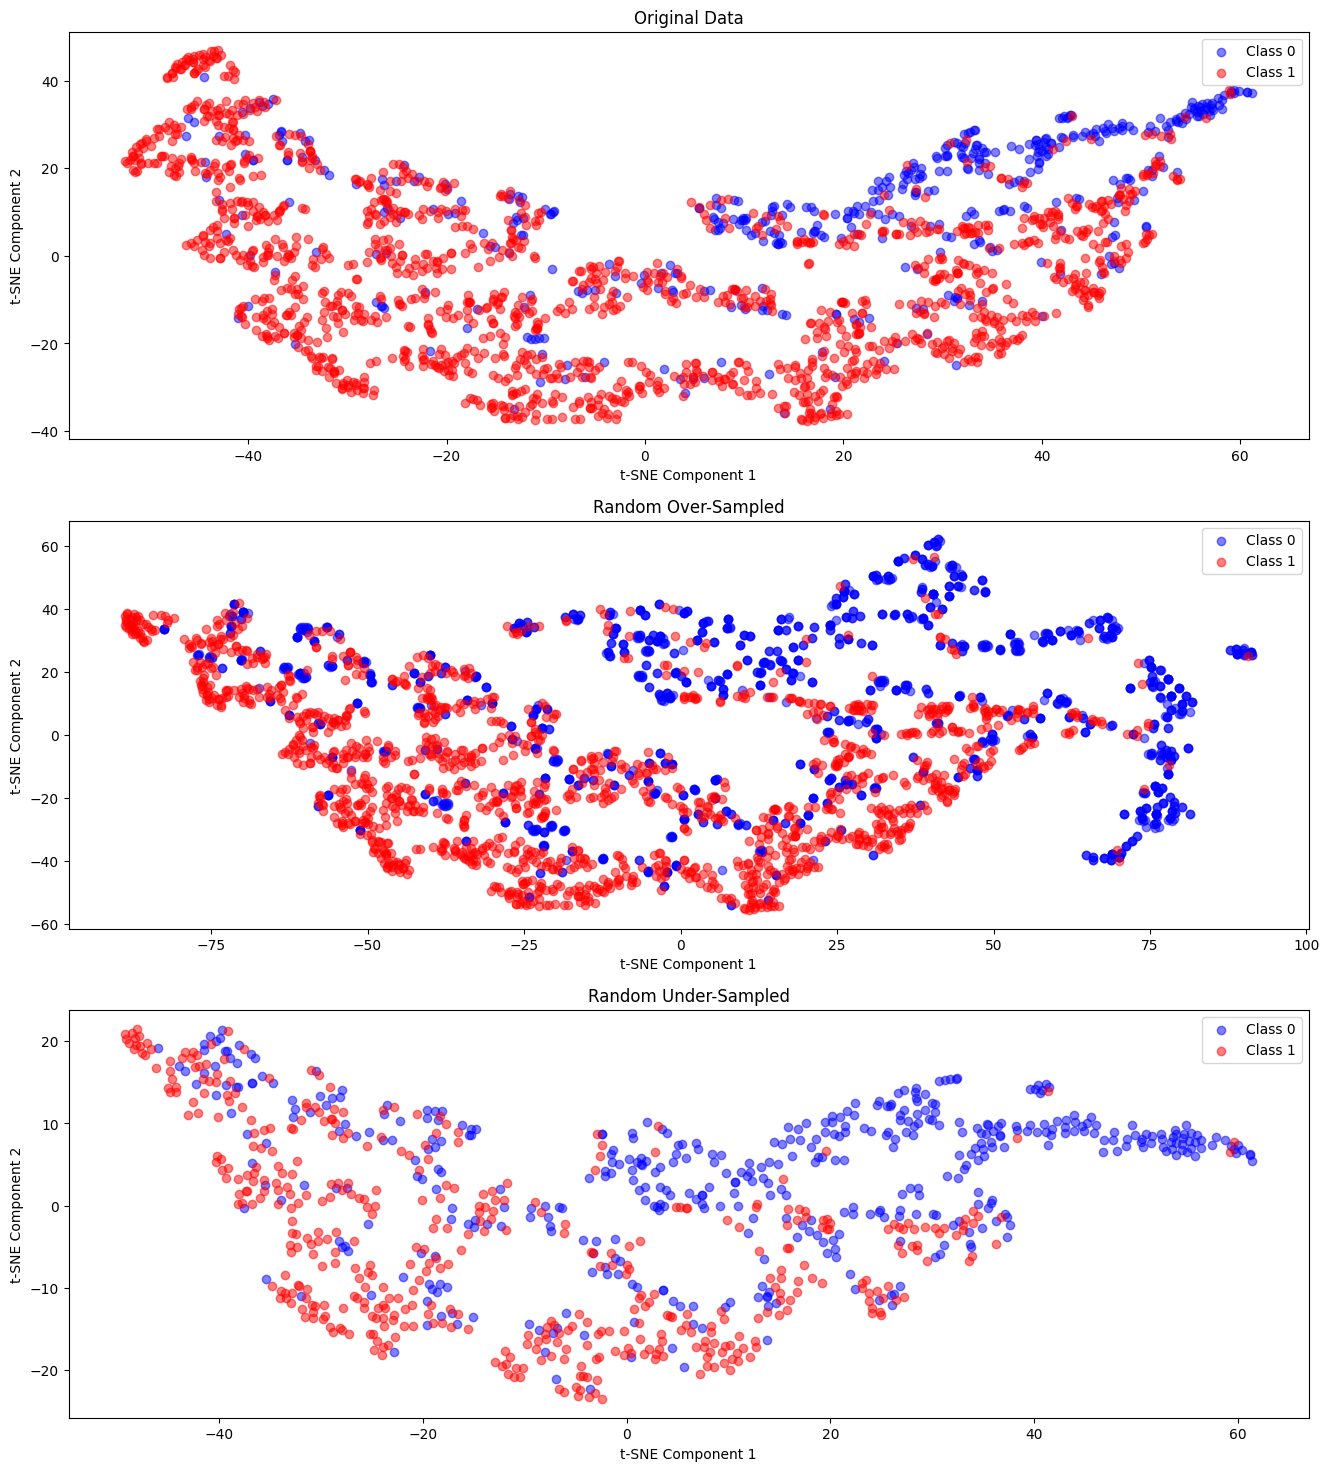

In [10]:
dfs = [df, df_ros, df_rus]
titles = ['Original Data', 'Random Over-Sampled', 'Random Under-Sampled']
plot_tsne(dfs, titles)

In [11]:
df_sel = df
df_rus_sel = df_rus
df_ros_sel = df_ros

### Baseline models

In [12]:
dfs = {
    'Imbalanced df': df,
    'Randomly undersampled df': df_rus,
    'Randomly oversampled df': df_ros
}

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

n_splits = 5  
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

trained_models = {}

for df_name, selected_df in dfs.items():
    feature_cols = selected_df.drop(['BBB', 'smiles'], axis=1).columns
    X = selected_df[feature_cols]
    y = selected_df['BBB']
    print(f"\nValidating models on {df_name}:")
    
    trained_models[df_name] = {}

    for name, model in models.items():
        fold_acc = [] 

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            
            model_clone = clone(model)
            model_clone.fit(X_train, y_train)
            y_pred = model_clone.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            fold_acc.append(accuracy)

        avg_accuracy = sum(fold_acc) / len(fold_acc)
        print(f"  Model: {name}, Average Accuracy: {avg_accuracy:.4f}")
        
        trained_models[df_name][name] = model_clone  


Validating models on Imbalanced df:
  Model: Logistic Regression, Average Accuracy: 0.9014
  Model: Decision Tree, Average Accuracy: 0.8585
  Model: Random Forest, Average Accuracy: 0.9117
  Model: Gradient Boosting, Average Accuracy: 0.8942
  Model: k-Nearest Neighbors, Average Accuracy: 0.8642
  Model: Naive Bayes, Average Accuracy: 0.7465

Validating models on Randomly undersampled df:
  Model: Logistic Regression, Average Accuracy: 0.8536
  Model: Decision Tree, Average Accuracy: 0.7929
  Model: Random Forest, Average Accuracy: 0.8699
  Model: Gradient Boosting, Average Accuracy: 0.8557
  Model: k-Nearest Neighbors, Average Accuracy: 0.7972
  Model: Naive Bayes, Average Accuracy: 0.7647

Validating models on Randomly oversampled df:
  Model: Logistic Regression, Average Accuracy: 0.9133
  Model: Decision Tree, Average Accuracy: 0.9282
  Model: Random Forest, Average Accuracy: 0.9699
  Model: Gradient Boosting, Average Accuracy: 0.9312
  Model: k-Nearest Neighbors, Average Accuracy

### Test trained models on exogenous dataset

In [24]:
features_ex = test.drop(columns=['BBB', 'smiles']).values
targets_ex = test['BBB'].values
smiles_ex = test['smiles'].values

valid_indices = validate_and_filter_smiles(smiles_ex)
valid_features_ex = features_ex[valid_indices]
valid_targets_ex = targets_ex[valid_indices]
valid_smiles_ex = smiles_ex[valid_indices]

test_dataset = dc.data.NumpyDataset(X=valid_features_ex, y=valid_targets_ex, ids=valid_smiles_ex)
sp(dc.splits.ScaffoldSplitter(), test_dataset)

def test_exogenous_models(trained_models, test_dataset, set_name="Test Set"):
    test_scores = {}
    for df_name, models_dict in trained_models.items():
        test_scores[df_name] = {}
        for model_name, model in models_dict.items():
            y_pred = model.predict(test_dataset.X)
            accuracy = dc.metrics.accuracy_score(test_dataset.y, y_pred)
            test_scores[df_name][model_name] = accuracy
    return test_scores

exogenous_test_scores = test_exogenous_models(trained_models, test_dataset)

def print_scores(scores, set_name):
    print(f"\n{set_name} Results:")
    for df_name, results in scores.items():
        print(f"\n  {df_name}:")
        for model_name, accuracy in results.items():
            print(f"    {model_name}: {accuracy:.4f}")

print_scores(exogenous_test_scores, "Exogenous Test Set")



Exogenous Test Set Results:

  Imbalanced df:
    Logistic Regression: 0.8686
    Decision Tree: 0.7676
    Random Forest: 0.8838
    Gradient Boosting: 0.8762
    k-Nearest Neighbors: 0.8362
    Naive Bayes: 0.6857

  Randomly undersampled df:
    Logistic Regression: 0.7962
    Decision Tree: 0.7733
    Random Forest: 0.8286
    Gradient Boosting: 0.8286
    k-Nearest Neighbors: 0.7390
    Naive Bayes: 0.6933

  Randomly oversampled df:
    Logistic Regression: 0.8400
    Decision Tree: 0.7562
    Random Forest: 0.8876
    Gradient Boosting: 0.8590
    k-Nearest Neighbors: 0.7600
    Naive Bayes: 0.7143


### AUC curve for baseline

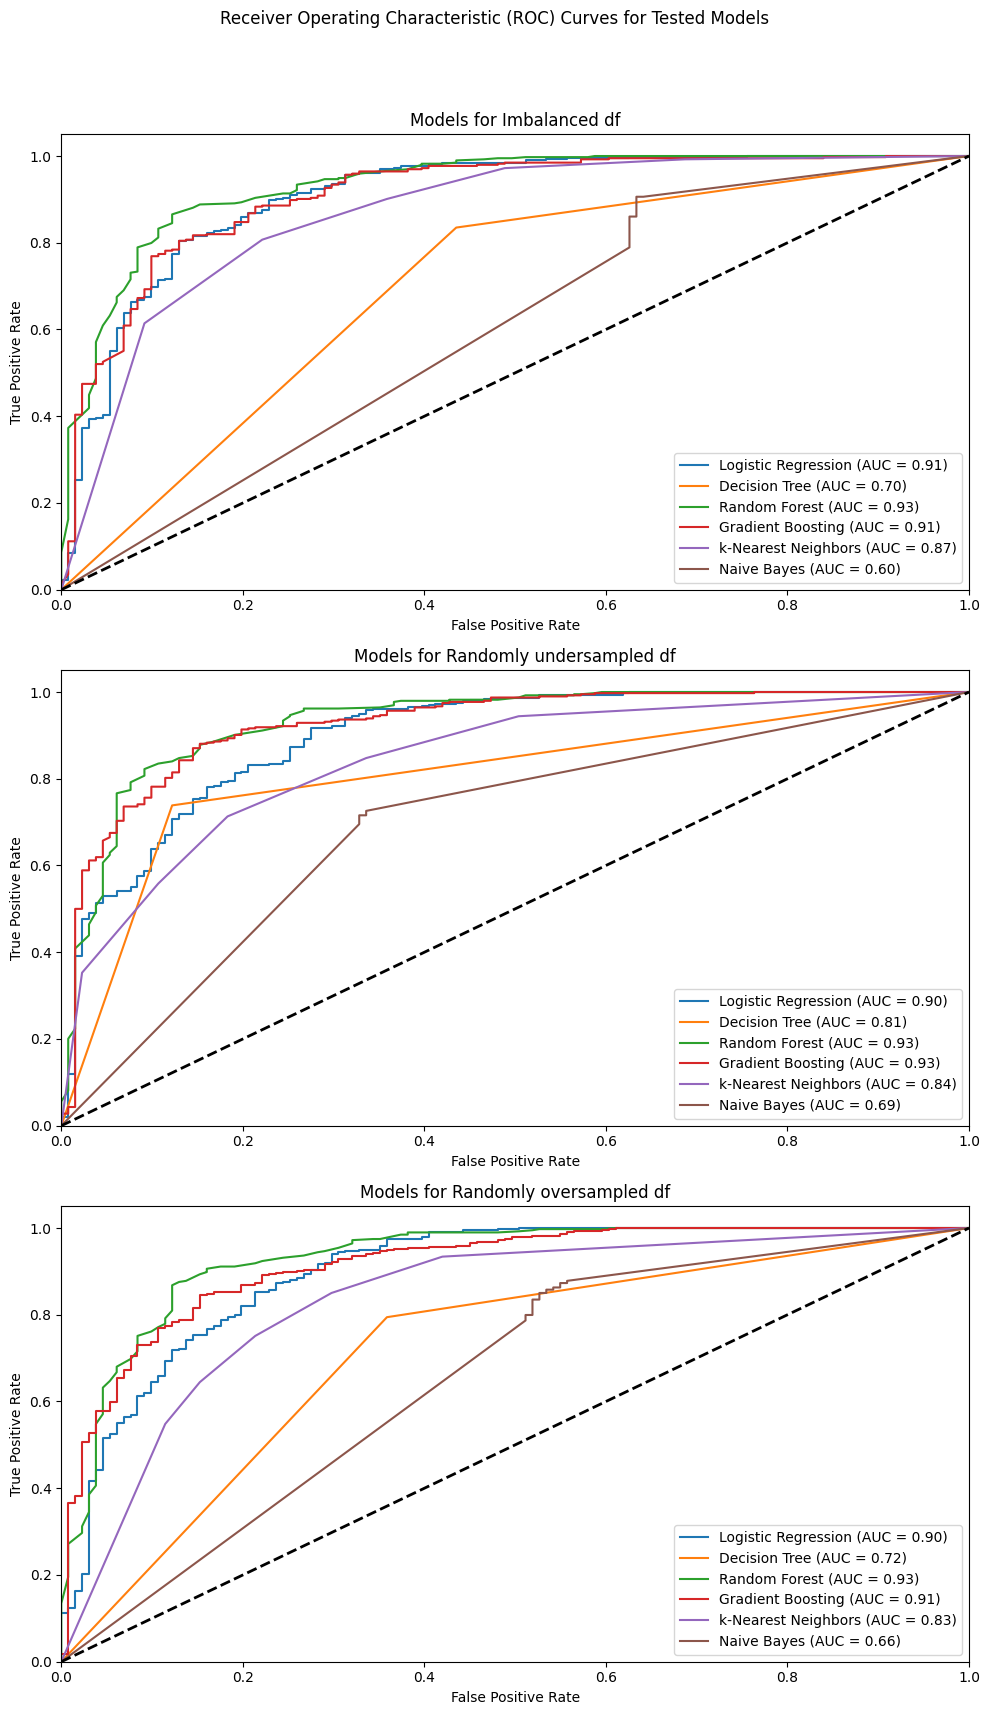

In [25]:
def plot_roc_curves(trained_models, test_dataset):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 18)) 
    fig.suptitle('Receiver Operating Characteristic (ROC) Curves for Tested Models')
    
    keys = list(trained_models.keys())
    
    for i, ax in enumerate(axes.flat):
        if i < len(keys):
            models_dict = trained_models[keys[i]]
            for model_name, model in models_dict.items():
                if hasattr(model, "predict_proba"): 
                    y_score = model.predict_proba(test_dataset.X)[:, 1]
                    fpr, tpr, _ = roc_curve(test_dataset.y, y_score)
                    roc_auc = auc(fpr, tpr)
                    ax.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
                else:
                    print(f"Model {model_name} does not support predict_proba and will be skipped.")
            
            ax.plot([0, 1], [0, 1], 'k--', lw=2)
            ax.set_xlim([0.0, 1.0])
            ax.set_ylim([0.0, 1.05])
            ax.set_xlabel('False Positive Rate')
            ax.set_ylabel('True Positive Rate')
            ax.set_title(f'Models for {keys[i]}')
            ax.legend(loc="lower right")
        else:
            fig.delaxes(ax) 

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
    plt.show()

plot_roc_curves(trained_models, test_dataset)

### Results with selected features

In [27]:
#feature selection
df_sel = apply_RFECV_and_add(df)
df_rus_sel = apply_RFECV_and_add(df_rus)
df_ros_sel = apply_RFECV_and_add(df_ros)

In [28]:
#creating 3 splits of test with same features
columns_sel = df_sel.columns
columns_ros_sel = df_ros_sel.columns
columns_rus_sel = df_rus_sel.columns
test_sel = test[columns_sel]
test_ros_sel = test[columns_ros_sel]
test_rus_sel = test[columns_rus_sel]

In [34]:
#training dfs with selected features against the same models as above
dfs = {
    'Imbalanced selected df': df_sel,
    'Randomly undersampled selected df': df_rus_sel,
    'Randomly oversampled selected df': df_ros_sel
}

models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB()
}

n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

trained_models_sel = {}

for df_name, selected_df in dfs.items():
    feature_cols = selected_df.drop(['BBB', 'smiles'], axis=1).columns
    X = selected_df[feature_cols]
    y = selected_df['BBB']
    print(f"\nVaidating models on {df_name}:")
    
    trained_models_sel[df_name] = {}

    for name, model in models.items():
        fold_acc = [] 

        for train_index, test_index in skf.split(X, y):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]

            model_clone = clone(model)
            model_clone.fit(X_train, y_train)
            y_pred = model_clone.predict(X_test)
            accuracy = accuracy_score(y_test, y_pred)
            fold_acc.append(accuracy)

        avg_accuracy = sum(fold_acc) / len(fold_acc) 
        print(f"  Model: {name}, Average Test Accuracy: {avg_accuracy:.4f}")
        
        trained_models_sel[df_name][name] = model_clone 


Vaidating models on Imbalanced selected df:
  Model: Logistic Regression, Average Test Accuracy: 0.8947
  Model: Decision Tree, Average Test Accuracy: 0.8616
  Model: Random Forest, Average Test Accuracy: 0.9143
  Model: Gradient Boosting, Average Test Accuracy: 0.8998
  Model: k-Nearest Neighbors, Average Test Accuracy: 0.8647
  Model: Naive Bayes, Average Test Accuracy: 0.8616

Vaidating models on Randomly undersampled selected df:
  Model: Logistic Regression, Average Test Accuracy: 0.8438
  Model: Decision Tree, Average Test Accuracy: 0.7983
  Model: Random Forest, Average Test Accuracy: 0.8775
  Model: Gradient Boosting, Average Test Accuracy: 0.8590
  Model: k-Nearest Neighbors, Average Test Accuracy: 0.8005
  Model: Naive Bayes, Average Test Accuracy: 0.8308

Vaidating models on Randomly oversampled selected df:
  Model: Logistic Regression, Average Test Accuracy: 0.9136
  Model: Decision Tree, Average Test Accuracy: 0.9333
  Model: Random Forest, Average Test Accuracy: 0.9699


In [35]:
def prepare_and_validate_dataset(df):
    features = df.drop(columns=['BBB', 'smiles']).values
    targets = df['BBB'].values
    smiles = df['smiles'].values

    valid_indices = validate_and_filter_smiles(smiles)
    valid_features = features[valid_indices]
    valid_targets = targets[valid_indices]
    valid_smiles = smiles[valid_indices]

    return dc.data.NumpyDataset(X=valid_features, y=valid_targets, ids=valid_smiles)

test_datasets = {
    'Imbalanced selected df': prepare_and_validate_dataset(test_sel),
    'Randomly undersampled selected df': prepare_and_validate_dataset(test_rus_sel),
    'Randomly oversampled selected df': prepare_and_validate_dataset(test_ros_sel)
}

def test_models(trained_models_dict, test_datasets_dict):
    all_test_scores = {}
    for df_name, test_dataset in test_datasets_dict.items():
        print(f"\nTesting models on {df_name}:")
        models_dict = trained_models_dict[df_name]
        test_scores = {}
        
        for model_name, model in models_dict.items():
            y_pred = model.predict(test_dataset.X)
            accuracy = dc.metrics.accuracy_score(test_dataset.y, y_pred)
            test_scores[model_name] = accuracy
            print(f"  Model: {model_name}, Accuracy: {accuracy:.4f}")
        
        all_test_scores[df_name] = test_scores

    return all_test_scores

final_scores = test_models(trained_models_sel, test_datasets)


Testing models on Imbalanced selected df:
  Model: Logistic Regression, Accuracy: 0.8686
  Model: Decision Tree, Accuracy: 0.7505
  Model: Random Forest, Accuracy: 0.8914
  Model: Gradient Boosting, Accuracy: 0.8686
  Model: k-Nearest Neighbors, Accuracy: 0.8438
  Model: Naive Bayes, Accuracy: 0.7390

Testing models on Randomly undersampled selected df:
  Model: Logistic Regression, Accuracy: 0.7867
  Model: Decision Tree, Accuracy: 0.7676
  Model: Random Forest, Accuracy: 0.8495
  Model: Gradient Boosting, Accuracy: 0.8324
  Model: k-Nearest Neighbors, Accuracy: 0.7314
  Model: Naive Bayes, Accuracy: 0.7448

Testing models on Randomly oversampled selected df:
  Model: Logistic Regression, Accuracy: 0.8305
  Model: Decision Tree, Accuracy: 0.7657
  Model: Random Forest, Accuracy: 0.8876
  Model: Gradient Boosting, Accuracy: 0.8571
  Model: k-Nearest Neighbors, Accuracy: 0.7619
  Model: Naive Bayes, Accuracy: 0.7029
